In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')
rdd = sc.parallelize(range(1000))
rdd.takeSample(False, 5)

Exception: Java gateway process exited before sending its port number

In [ ]:
# import necessary libraries
from pyspark.sql import SparkSession

# instantiate SparkSession object
spark = SparkSession.builder.master('local').getOrCreate()

spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [ ]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('./small_data/ml-latest-small/ratings.csv', header='true', inferSchema='true')

In [ ]:
movie_ratings = movie_ratings.drop('timestamp')

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.recommendation import ALS

# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [8]:
# importing appropriate library
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

NameError: name 'model' is not defined

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()


# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

# Incorporating Movie Titles

In [ ]:
movie_titles = spark.read.csv('./data/movies.csv',header='true',inferSchema='true')

movie_titles.head(5)

In [ ]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [ ]:
print(name_retriever(1023, movie_titles))

# Getting Recs

In [ ]:
users = movie_ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [ ]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]

# use the name retriever function to get the values
name_retriever(first_recommendation,movie_titles)

In [ ]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

# Preds for New User

In [ ]:
[Row(movieId=3253, title='Wayne's World (1992)', genres='Comedy'),
 Row(movieId=2459, title='Texas Chainsaw Massacre, The (1974)', genres='Horror'),
 Row(movieId=2513, title='Pet Sematary (1989)', genres='Horror'),
 Row(movieId=6502, title='28 Days Later (2002)', genres='Action|Horror|Sci-Fi'),
 Row(movieId=1091, title='Weekend at Bernie's (1989)', genres='Comedy'),
Row(movieId=441, title='Dazed and Confused (1993)', genres='Comedy'),
Row(movieId=370, title='Naked Gun 33 1/3: The Final Insult (1994)', genres='Action|Comedy')]

In [ ]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # split the dataframe into a train and test set
#     (training, test) = movie_ratings_combined.randomSplit([0.8, 0.2],seed=0)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5,rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id,movie_title_df)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1,movie_string,rating))

In [ ]:
user_id = 100000
user_ratings_1 = [(user_id,3253,5),
                  (user_id,2459,5),
                  (user_id,2513,4),
                  (user_id,6502,5),
                  (user_id,1091,5),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df=movie_titles,
             num_recs = 10)

# Content Filtering

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
movies = pd.read_csv('small_data/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
tags = pd.read_csv('small_data/ml-latest-small/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
# movie profile
movie_profile = movies[['movieId', 'title', 'genres']]
movie_profile.rename(columns={'id': 'movieId'}, inplace=True)
genres = [item.strip() for l in all_genres for item in l ]
unique_genres = set(genres)
for genre in unique_genres:
  movie_profile[genre] = 0
  
for i in range(len(movie_profile)):
  if type(movie_profile['genres'].iloc[i]) != None.__class__:
    Genres = movie_profile.iloc[i].genres.split(', ')
    for g in Genres:
      movie_profile[g].iloc[i] = 1
movie_profile = movie_profile.drop(columns=['title', 'genres']).set_index('movieId')
movie_profile.sort_index(axis=0, inplace=True)

# user profile
user_x_movie = pd.pivot_table(ratings, values='rating', index=['movieId'], columns = ['userId'])
user_x_movie.sort_index(axis=0, inplace=True)
userIDs = user_x_movie.columns
user_profile = pd.DataFrame(columns = movie_profile.columns)

for i in tqdm(range(len(user_x_movie.columns))):
  working_df = movie_profile.mul(user_x_movie.iloc[:,i], axis=0)
  # working_df.replace(0, np.NaN, inplace=True)    
  user_profile.loc[userIDs[i]] = working_df.mean(axis=0)
  
# TFIDF
df = movie_profile.sum()
idf = (len(movies)/df).apply(np.log) #log inverse of DF
TFIDF = movie_profile.mul(idf.values)

# recommendation prediction
df_predict = pd.DataFrame()

for i in tqdm(range(len(user_x_movie.columns))):
  working_df = TFIDF.mul(user_profile.iloc[i], axis=1)
  df_predict[user_x_movie.columns[i]] = working_df.sum(axis=1) 

NameError: name 'all_genres' is not defined

In [11]:
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09


In [16]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                             lambda x: "%s" % ' '.join(x)))

In [20]:
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                             lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure|Animation|Children|C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy|Romance


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(9742, 1677)


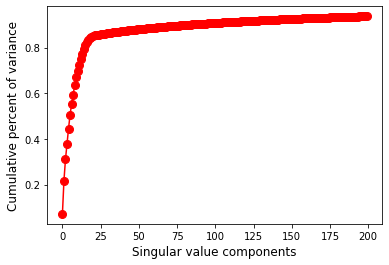

In [24]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(Content_df.loc['Inception (2010)']).reshape(1, -1)
a_2 = np.array(Collab_df.loc['Inception (2010)']).reshape(1, -1)
 
# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(Content_df, a_1).reshape(-1)
score_2 = cosine_similarity(Collab_df, a_2).reshape(-1)
 
# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)
 
# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = Content_df.index )
 
#sort it on the basis of either: content, collaborative or hybrid 
similar.sort_values('content', ascending=False, inplace=True)
similar[['content']][1:].head(11)

NameError: name 'Content_df' is not defined

# Content Filtering 2

In [1]:
# https://github.com/vivdalal/movie-recommender-system/blob/master/movie_recommendation_system.ipynb

In [2]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [3]:
# Reading ratings file
ratings = pd.read_csv('small_data/ml-latest-small/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('small_data/ml-latest-small/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [4]:
df_movies = movies 
df_ratings = ratings

<BarContainer object of 19 artists>

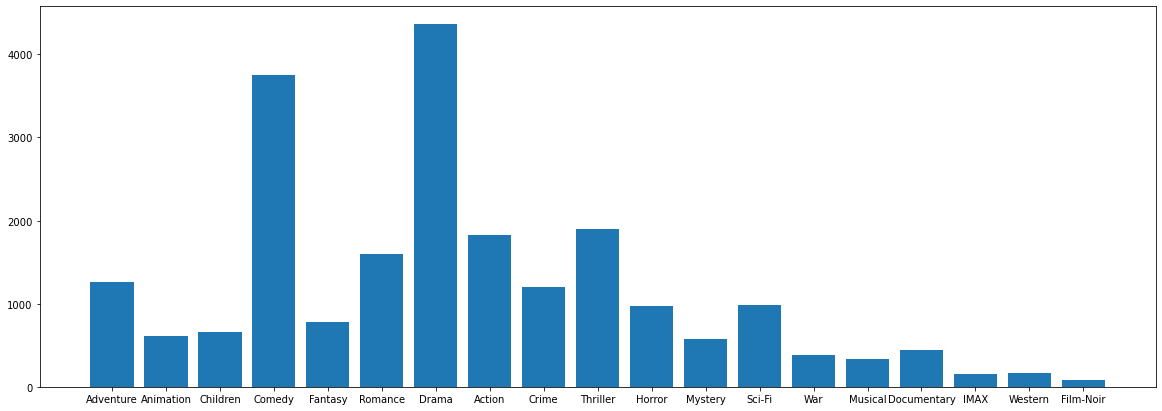

In [5]:
# distribution of genre counts
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values())

C:\Users\nehcr\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


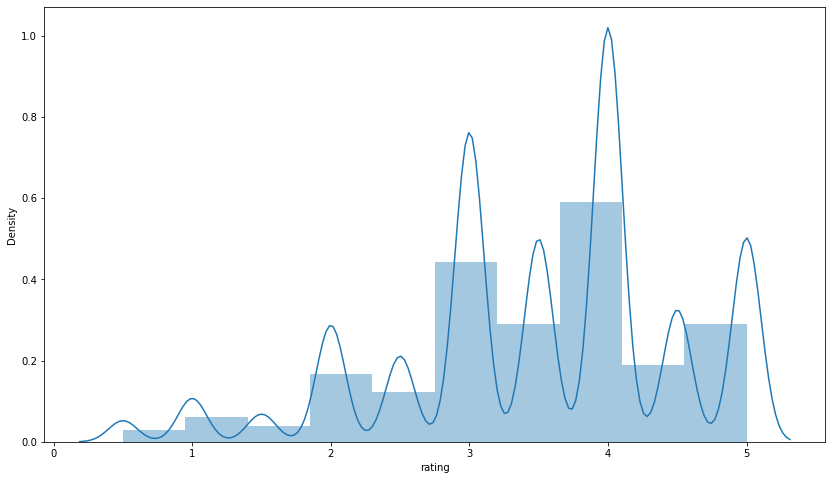

In [14]:
# ratings distribution
fig, ax = plt.subplots(figsize = (14,8))
sns.set_color_codes()
sns.distplot(df_ratings["rating"], bins = 10);

In [34]:
# merge ratings 
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [35]:
# drop timestamp column 
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

## Ratings Distributions

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
# we should keep in mind that there are duplicate entries
movies[movies.title.duplicated(keep=False)].sort_values(by='title')

,movieId,title,genres
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
650,838,Emma (1996),Comedy|Drama|Romance
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
9135,147002,Eros (2004),Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi


In [17]:
df = pd.merge(ratings, movies, on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [18]:
ratings_df = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_df.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [19]:
ratings_df.rename(columns={'rating': 'average_rating'}, inplace=True)
ratings_df.head(3)

,average_rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5


In [20]:
ratings_df['num_of_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings_df.head()

,average_rating,num_of_ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


Text(0, 0.5, 'number of films with that many ratings')

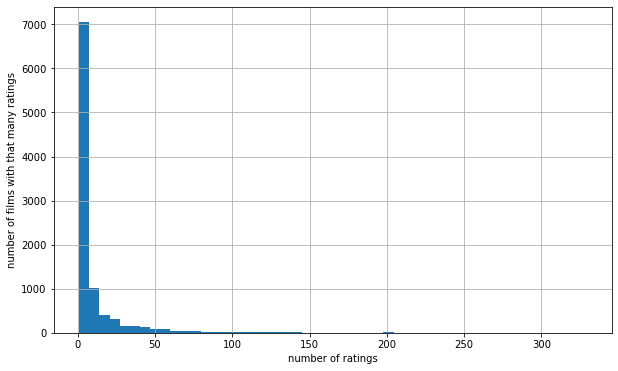

In [21]:
# Number of films with a specific number of ratings
plt.figure(figsize=[10,6]) # Using basic pandas visualisation
ratings_df['num_of_ratings'].hist(bins=50)
plt.xlabel('number of ratings')
plt.ylabel('number of films with that many ratings')

Text(0, 0.5, 'number of films with that rating')

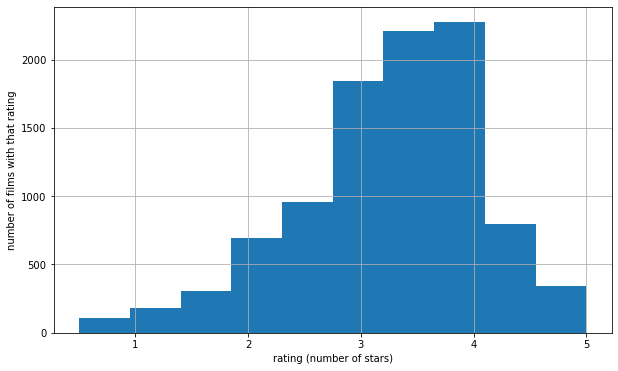

In [22]:
# Distribution of film ratings
plt.figure(figsize=[10,6])
ratings_df.average_rating.hist(bins=10)
plt.xlabel('Rating (number of stars)')
plt.ylabel('Film Counts')

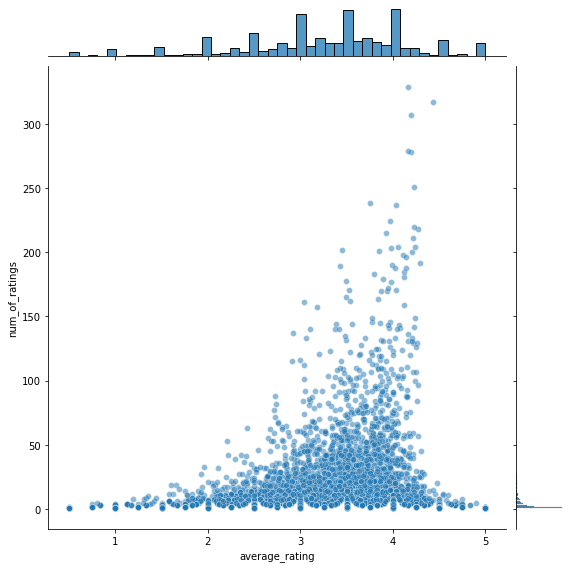

In [52]:
# average ratings and number of ratings
fig = sns.jointplot(x='average_rating',y='num_of_ratings', data=ratings_df, alpha=0.5, height = 8, ratio = 8)
plt.savefig('images/rating_distribution_scatter')

## 

In [36]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])

In [37]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

<AxesSubplot:xlabel='userId'>

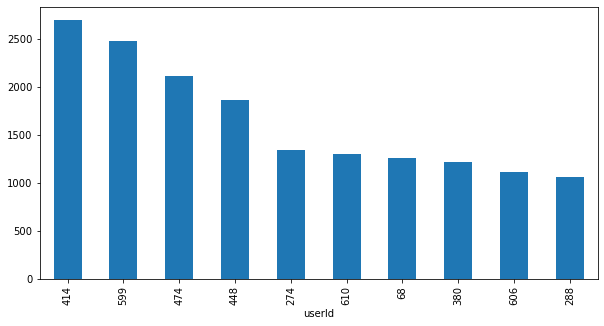

In [69]:
# top 10 users with most ratings
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind='bar', figsize = (10,5))

In [41]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)

In [43]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

## Movies with highest average ratings

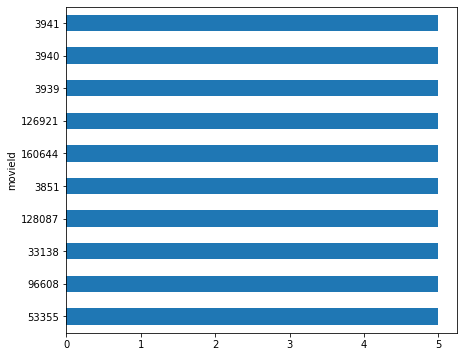

In [44]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

## Content Based Filtering

In [53]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [45]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
# print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
# print(tfidf_movies_genres_matrix.shape)
# print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
# print(cosine_sim_movies)

In [48]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:6]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return df_movies['title'].iloc[movie_indices]

In [49]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                        Four Rooms (1995)
18    Ace Ventura: When Nature Calls (1995)
58                          Bio-Dome (1996)
61                            Friday (1995)
79                       Black Sheep (1996)
Name: title, dtype: object

In [51]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(1)

{'101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 '39 Steps, The (1935)',
 '5,000 Fingers of Dr. T, The (1953)',
 'Absolute Power (1997)',
 'Ace Ventura: When Nature Calls (1995)',
 'Adventures in Babysitting (1987)',
 'Adventures of Baron Munchausen, The (1988)',
 'Adventures of Buckaroo Banzai Across the 8th Dimension, The (1984)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Adventures of Sharkboy and Lavagirl 3-D, The (2005)',
 'Agent Cody Banks (2003)',
 'Aladdin (1992)',
 'Alamo, The (1960)',
 'Alien Nation (1988)',
 'All Dogs Christmas Carol, An (1998)',
 'All Dogs Go to Heaven 2 (1996)',
 'Allan Quatermain and the Lost City of Gold (1987)',
 'Almost Heroes (1998)',
 'Alvin and the Chipmunks: The Squeakquel (2009)',
 'Amateur (1994)',
 'Amazing Panda Adventure, The (1995)',
 'American Astronaut, The (2001)',
 'American Pop (1981)',
 'Amistad (1997)',
 'Anastasia (1997)',
 'Annie (1982)',
 "Antonia's Line (Antonia) (1995)",
 'Antz (1998)',
 'Apocalypse Now (1979

In [52]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = df_movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [53]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in df_movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
#                 print(colums["genres"])
#                 print(predicted_genre)
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.9126052145350031
Fault:0.08739478546499692
